<a href="https://colab.research.google.com/github/Mindauskas/generate_cats/blob/master/generate_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass
%matplotlib inline

In [0]:
SETUP = True

In [3]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

     |████████████████████████████████| 153kB 7.3MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 296kB 72.8MB/s 
     |████████████████████████████████| 552kB 68.1MB/s 
     |████████████████████████████████| 61kB 11.1MB/s 
     |████████████████████████████████| 122kB 63.3MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 102kB 3.6MB/s 
     |████████████████████████████████| 747kB 7.0MB/s 
     |████████████████████████████████| 993kB 5.1MB/s 
0.3.9
2.1.0-rc1


In [4]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the env

In [0]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

**1. Download data**

In [6]:
(
    (train_data, train_labels),
    (_,_),
) = keras.datasets.cifar10.load_data()

train_data = train_data.astype(np.float32) / 255

170500096/170498071 [==============================] - 4s 0us/step


In [7]:
train_data.shape

(50000, 32, 32, 3)

In [8]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [9]:
train_data.shape

(50000, 32, 32, 3)

In [10]:
train_labels.shape

(50000, 1)

Let's work with cats

In [0]:
train_data = train_data[train_labels.flatten()==3]

In [12]:
train_data.shape

(5000, 32, 32, 3)

In [0]:
VALIDATION_SIZE = 2000
train_data, validation_data = (
    train_data[:-VALIDATION_SIZE],
    train_data[-VALIDATION_SIZE:],
)

In [14]:
print(train_data.shape)
print(validation_data.shape)

(3000, 32, 32, 3)
(2000, 32, 32, 3)


In [0]:
def plot_dataset(n, data):
  for i in range(n):
    plt.subplot(3, 3, 3)
    plt.imshow(data[i])
    plt.show()

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [0]:
def show_images(images: np.ndarray , n_images: int = 5):
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])


In [0]:
show_images(train_data, 20)

In [0]:
def show_reconstructions(
    model: keras.Model, images: np.ndarray = validation_data, n_images: int = 5
):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

**2. Stacked autoencoders**

In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
stacked_encoder = keras.models.Sequential(
    [
     keras.layers.Flatten(input_shape=[32, 32, 3]),
     keras.layers.Dense(128, activation=keras.activations.selu),
     keras.layers.Dense(32, activation=keras.activations.selu),
     ]
)

In [0]:
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Dense(128, activation=keras.activations.selu, input_shape=[32]),
        keras.layers.Dense(32 * 32 * 3, activation=keras.activations.sigmoid),
        keras.layers.Reshape([32, 32, 3]),
    ]
)

In [0]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [0]:
stacked_ae.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.SGD(lr=5e-1),
    metrics=[rounded_accuracy],
)

In [25]:
history = stacked_ae.fit(
    train_data,
    train_data,
    epochs=50,
    validation_data=[validation_data, validation_data],
)

Train on 3000 samples, validate on 2000 samples
Epoch 1/50
3000/3000 [==============================] - 3s 892us/sample - loss: 0.6937 - rounded_accuracy: 0.5116 - val_loss: 0.6927 - val_rounded_accuracy: 0.5221
Epoch 2/50
3000/3000 [==============================] - 0s 159us/sample - loss: 0.6914 - rounded_accuracy: 0.5356 - val_loss: 0.6899 - val_rounded_accuracy: 0.5498
Epoch 3/50
3000/3000 [==============================] - 0s 161us/sample - loss: 0.6871 - rounded_accuracy: 0.5692 - val_loss: 0.6841 - val_rounded_accuracy: 0.5865
Epoch 4/50
3000/3000 [==============================] - 0s 158us/sample - loss: 0.6795 - rounded_accuracy: 0.6075 - val_loss: 0.6754 - val_rounded_accuracy: 0.6217
Epoch 5/50
3000/3000 [==============================] - 0s 162us/sample - loss: 0.6702 - rounded_accuracy: 0.6398 - val_loss: 0.6665 - val_rounded_accuracy: 0.6500
Epoch 6/50
3000/3000 [==============================] - 0s 163us/sample - loss: 0.6616 - rounded_accuracy: 0.6638 - val_loss: 0.6585

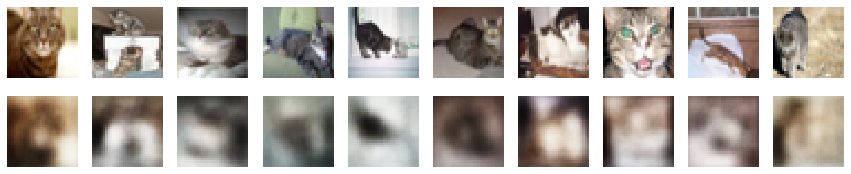

In [44]:
show_reconstructions(stacked_ae, n_images=10)

In [27]:
history = stacked_ae.fit(
    train_data,
    train_data,
    epochs=500,
    validation_data=[validation_data, validation_data],
)

Train on 3000 samples, validate on 2000 samples
Epoch 1/500
3000/3000 [==============================] - 0s 166us/sample - loss: 0.5914 - rounded_accuracy: 0.8246 - val_loss: 0.5910 - val_rounded_accuracy: 0.8249
Epoch 2/500
3000/3000 [==============================] - 1s 169us/sample - loss: 0.5907 - rounded_accuracy: 0.8261 - val_loss: 0.5909 - val_rounded_accuracy: 0.8252
Epoch 3/500
3000/3000 [==============================] - 1s 173us/sample - loss: 0.5904 - rounded_accuracy: 0.8265 - val_loss: 0.5906 - val_rounded_accuracy: 0.8256
Epoch 4/500
3000/3000 [==============================] - 0s 156us/sample - loss: 0.5906 - rounded_accuracy: 0.8261 - val_loss: 0.5903 - val_rounded_accuracy: 0.8261
Epoch 5/500
3000/3000 [==============================] - 0s 164us/sample - loss: 0.5896 - rounded_accuracy: 0.8283 - val_loss: 0.5907 - val_rounded_accuracy: 0.8245
Epoch 6/500
3000/3000 [==============================] - 1s 177us/sample - loss: 0.5894 - rounded_accuracy: 0.8286 - val_loss: 

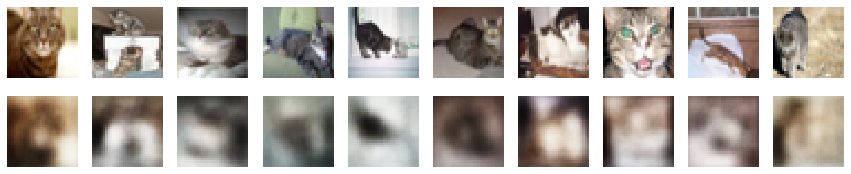

In [45]:
show_reconstructions(stacked_ae, n_images=10)

**Encoders with Conv layers**

In [0]:
conv_encoder = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            16, 
            kernel_size=3, 
            strides=2, 
            padding="VALID", 
            activation=keras.activations.selu,
            input_shape=[32,32,3]
        ),
        keras.layers.Conv2D(
            32, kernel_size=3, strides=2, padding="VALID", activation=keras.activations.selu
        ),
        keras.layers.Conv2D(
            64, kernel_size=3, strides=2, padding="VALID", activation=keras.activations.selu
        ),
    ]
)

In [30]:
conv_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_decoder = keras.models.Sequential(
    [
        keras.layers.Conv2DTranspose(
            32,
            kernel_size=3,
            strides=2,
            padding="VALID",
            activation=keras.activations.selu,
            input_shape=[3, 3, 64],
        ),
        keras.layers.Conv2DTranspose(
            16,
            kernel_size=3,
            strides=2,
            padding="VALID",
            activation=keras.activations.selu,
        ),
        keras.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="VALID",
            activation=keras.activations.sigmoid,
        ),
    ]
)

In [32]:
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 3)         771       
Total params: 23,859
Trainable params: 23,859
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [0]:
conv_ae.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.SGD(lr=5e-1),
    metrics=[rounded_accuracy],
)

In [35]:
history = conv_ae.fit(
    train_data, train_data, epochs=10, validation_data=[validation_data, validation_data]
)

Train on 3000 samples, validate on 2000 samples
Epoch 1/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.6871 - rounded_accuracy: 0.5855 - val_loss: 0.6847 - val_rounded_accuracy: 0.5984
Epoch 2/10
3000/3000 [==============================] - 1s 204us/sample - loss: 0.6597 - rounded_accuracy: 0.6780 - val_loss: 0.6183 - val_rounded_accuracy: 0.7898
Epoch 3/10
3000/3000 [==============================] - 1s 195us/sample - loss: 0.6123 - rounded_accuracy: 0.8091 - val_loss: 0.6043 - val_rounded_accuracy: 0.8290
Epoch 4/10
3000/3000 [==============================] - 1s 200us/sample - loss: 0.6022 - rounded_accuracy: 0.8313 - val_loss: 0.5986 - val_rounded_accuracy: 0.8395
Epoch 5/10
3000/3000 [==============================] - 1s 207us/sample - loss: 0.5963 - rounded_accuracy: 0.8419 - val_loss: 0.5921 - val_rounded_accuracy: 0.8522
Epoch 6/10
3000/3000 [==============================] - 1s 212us/sample - loss: 0.5921 - rounded_accuracy: 0.8484 - val_loss: 0.5902 -

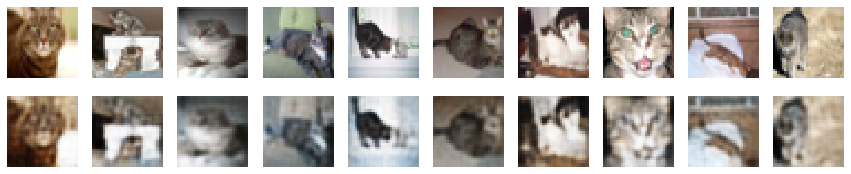

In [46]:
show_reconstructions(conv_ae, n_images=10)

In [37]:
history = conv_ae.fit(
    train_data, train_data, epochs=100, validation_data=[validation_data, validation_data]
)

Train on 3000 samples, validate on 2000 samples
Epoch 1/100
3000/3000 [==============================] - 1s 221us/sample - loss: 0.5796 - rounded_accuracy: 0.8611 - val_loss: 0.5753 - val_rounded_accuracy: 0.8706
Epoch 2/100
3000/3000 [==============================] - 1s 209us/sample - loss: 0.5772 - rounded_accuracy: 0.8652 - val_loss: 0.5758 - val_rounded_accuracy: 0.8677
Epoch 3/100
3000/3000 [==============================] - 1s 218us/sample - loss: 0.5757 - rounded_accuracy: 0.8674 - val_loss: 0.5718 - val_rounded_accuracy: 0.8762
Epoch 4/100
3000/3000 [==============================] - 1s 208us/sample - loss: 0.5742 - rounded_accuracy: 0.8693 - val_loss: 0.5711 - val_rounded_accuracy: 0.8774
Epoch 5/100
3000/3000 [==============================] - 1s 217us/sample - loss: 0.5734 - rounded_accuracy: 0.8707 - val_loss: 0.5728 - val_rounded_accuracy: 0.8685
Epoch 6/100
3000/3000 [==============================] - 1s 206us/sample - loss: 0.5718 - rounded_accuracy: 0.8727 - val_loss: 

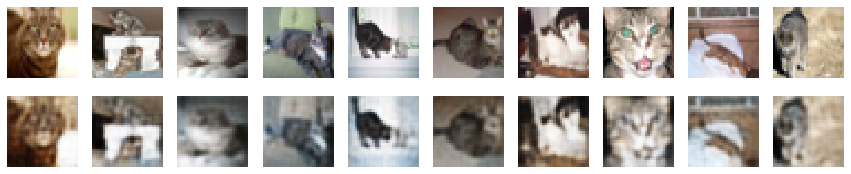

In [47]:
show_reconstructions(conv_ae, n_images=10)

In [39]:
history = conv_ae.fit(
    train_data, train_data, epochs=500, validation_data=[validation_data, validation_data]
)

Train on 3000 samples, validate on 2000 samples
Epoch 1/500
3000/3000 [==============================] - 1s 203us/sample - loss: 0.5505 - rounded_accuracy: 0.9239 - val_loss: 0.5497 - val_rounded_accuracy: 0.9270
Epoch 2/500
3000/3000 [==============================] - 1s 207us/sample - loss: 0.5505 - rounded_accuracy: 0.9233 - val_loss: 0.5506 - val_rounded_accuracy: 0.9238
Epoch 3/500
3000/3000 [==============================] - 1s 213us/sample - loss: 0.5511 - rounded_accuracy: 0.9217 - val_loss: 0.5504 - val_rounded_accuracy: 0.9240
Epoch 4/500
3000/3000 [==============================] - 1s 205us/sample - loss: 0.5507 - rounded_accuracy: 0.9226 - val_loss: 0.5505 - val_rounded_accuracy: 0.9247
Epoch 5/500
3000/3000 [==============================] - 1s 201us/sample - loss: 0.5508 - rounded_accuracy: 0.9223 - val_loss: 0.5500 - val_rounded_accuracy: 0.9252
Epoch 6/500
3000/3000 [==============================] - 1s 201us/sample - loss: 0.5498 - rounded_accuracy: 0.9264 - val_loss: 

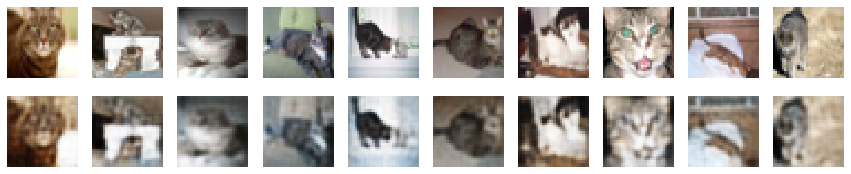

In [48]:
show_reconstructions(conv_ae, n_images=10)